# Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1)

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
arena_members = pd.read_csv('data/data_arena_members.csv')
arenas = pd.read_csv('data/data_arenas.csv')

In [3]:
arena_members = arena_members.merge(arenas[['arena_id', 'battle_type_id', 'battle_level_id', 'winner_team_id']], how='left', on='arena_id')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,2790,15,20,16533,0,0,0,1,9,2
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,829,15,10,4468,0,0,0,1,9,2
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,240,15,10,5419,1030,0,0,1,9,2
3,2018-09-16,7N1T221ccNyadyccT,202,ca1a2y2cy,1,0,0,0,529,330,...,343,15,10,18874,0,0,0,1,9,2
4,2018-09-16,7N1T221ccNyadyccT,202,caca47y7a,2,0,0,0,10257,379,...,3190,15,20,10470,840,0,0,1,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427925,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,494,15,10,26773,1560,0,0,1,8,1
2427926,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1415,15,10,3869,1790,0,0,1,8,1
2427927,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,380,15,10,58261,390,0,0,1,8,1
2427928,2018-10-10,cTacc2711d4da4y,202,c44d7NNNa,2,500138173,0,0,15649,336,...,337,15,10,27681,0,0,0,1,8,1


# Utils

In [4]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_distributions(catalog,
                        price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        ax.hist(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values, \
                bins=20)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_network(inputs):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[inputs]),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    
    return model

def plot_network_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.plot(hist['epoch'], hist['loss'], label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
    plt.ylim([0,1])
    plt.legend()

    plt.show()

# Catalog cleaning

In [5]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000)),
    
    ('cleaning by premium: item_level <= 8', \
    (catalog['item_price_gold'] == 0) | (catalog['item_level'] <= 8))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows. ({100 * (1 - len(catalog) / N)} %)')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows. ({100 * len(removed_tanks) / (len(removed_tanks) + len(catalog))} %)')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows. (0.7882882882882858 %)
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows. (1.0215664018161208 %)
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows. (11.238532110091748 %)
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows. (2.5839793281653756 %)
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows. (0.13262599469495706 %)
[CLEANING BY PREMIUM: ITEM_LEVEL <= 8]: removed 18 rows. (2.39043824701195 %)

Totally removed 153 rows. (17.22972972972973 %)


In [6]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

classEncoder = LabelEncoder()
catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
730,64817,3,0,3500,6,5
731,65041,1,0,0,1,6
732,65073,2,0,12250,8,4
733,65297,2,0,12500,8,5


In [7]:
N0 = len(catalog)

print(f'Catalog shape: {catalog.shape}\n')

N = len(catalog)
print('[REMOVING DUPLICATES...]', end='   ')
catalog = catalog.dropna()
print(f'[REMOVED: {N - len(catalog)}] ({100 * (1 - len(catalog) / N)} %)')

N = len(catalog)
print('[REMOVING NAN...]', end='   ')
catalog = catalog[~catalog.isna()]
print(f'[REMOVED: {N - len(catalog)}] ({100 * (1 - len(catalog) / N)} %)')

print(f'\nTotally removed {N0 - len(catalog)} rows. ({100 * (1 - len(catalog) / N0)} %)\n')

catalog.info()

Catalog shape: (735, 6)

[REMOVING DUPLICATES...]   [REMOVED: 0] (0.0 %)
[REMOVING NAN...]   [REMOVED: 0] (0.0 %)

Totally removed 0 rows. (0.0 %)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 734
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   item_cd            735 non-null    category
 1   item_class         735 non-null    int32   
 2   item_price_credit  735 non-null    int64   
 3   item_price_gold    735 non-null    int64   
 4   item_level         735 non-null    int64   
 5   crew_size          735 non-null    int64   
dtypes: category(1), int32(1), int64(4)
memory usage: 58.8 KB


In [8]:
s1 = set(removed_tanks['item_cd'])
s2 = set(arena_members['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{13889, 58625, 61697, 15905, 46849, 15617, 65281, 58369, 55841, 9297, 6225, 63537, 58641, 60945}


# Catalog visualizing

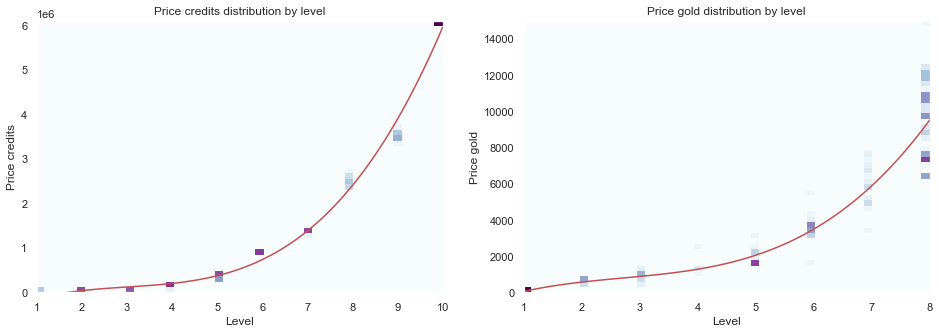

In [9]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

In [ ]:
price_distributions(creds_catalog, price='creds')

In [ ]:
price_distributions(gold_catalog, price='gold')

In [ ]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

In [ ]:
sns.countplot(catalog['item_level']);

In [ ]:
sns.countplot(catalog['crew_size']);

# Arenas data cleaning

In [10]:
N0 = len(arena_members)

masks = [
    ('sync with catalog: vehicle_type_cd not in removed_ids', \
    ~arena_members['vehicle_type_cd'].isin(removed_ids)),
    
    ('removing not standard battles: battle_type_id == 1', \
    arena_members['battle_type_id'] == 1)
]

for mask in masks:
    N = len(arena_members)
    
    arena_members = arena_members.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N)} %)')
    
arena_members.index = np.arange(len(arena_members))

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

[SYNC WITH CATALOG: VEHICLE_TYPE_CD NOT IN REMOVED_IDS]: removed 6806 rows. (0.28032109657197823 %)
[REMOVING NOT STANDARD BATTLES: BATTLE_TYPE_ID == 1]: removed 34193 rows. (1.4122779337200408 %)

Totally removed 40999 rows. (1.6886401173015653 %)


In [11]:
for feature in ['clan_db_id', 'is_prebattle_creator']:
    arena_members[feature] = pd.Categorical(arena_members[feature])

arena_members['dt'] = pd.to_datetime(arena_members['dt'])

In [12]:
N0 = len(arena_members)

print(f'Arena members shape: {arena_members.shape}\n')

N = len(arena_members)
print('[REMOVING DUPLICATES...]', end='   ')
arena_members = arena_members.dropna()
print(f'[REMOVED: {N - len(arena_members)}] ({100 * (1 - len(arena_members) / N)} %)')

N = len(arena_members)
print('[REMOVING NAN...]', end='   ')
arena_members = arena_members[~arena_members.isna()]
print(f'[REMOVED: {N - len(arena_members)}] ({100 * (1 - len(arena_members) / N)} %)')

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

arena_members.info()

Arena members shape: (2386931, 38)

[REMOVING DUPLICATES...]   [REMOVED: 0] (0.0 %)
[REMOVING NAN...]   [REMOVED: 0] (0.0 %)

Totally removed 0 rows. (0.0 %)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2386931 entries, 0 to 2386930
Data columns (total 38 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   dt                        datetime64[ns]
 1   arena_id                  object        
 2   periphery_id              int64         
 3   account_db_id             object        
 4   team_id                   int64         
 5   clan_db_id                category      
 6   prebattle_id              int64         
 7   is_prebattle_creator      category      
 8   vehicle_type_cd           int64         
 9   life_time_sec             int64         
 10  shots                     int64         
 11  hits                      int64         
 12  he_hits                   int64         
 13  pierced                   int64   

# Creating normed by time features

In [13]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0

normalize_feature = np.vectorize(normalize_feature)

In [14]:
arena_members['total_damage_dealt'] = arena_members['damage_dealt'] + arena_members['damage_assisted_radio'] + \
                                      arena_members['damage_assisted_stun'] + arena_members['damage_assisted_track']

arena_members['life_time_min'] = arena_members['life_time_sec'] / 60

# Restoring winrates

In [ ]:
def calc_winner(row):
    winner = 0
    if row['num_tanks_pos_1'] != 0 and row['num_tanks_pos_2'] == 0:
        winner = 1
    elif row['num_tanks_pos_2'] != 0 and row['num_tanks_pos_1'] == 0:
        winner = 2
    else:
        if row['mean_xp_1'] / row['mean_xp_2'] > 1.8:
            winner = 1
        elif row['mean_xp_2'] / row['mean_xp_1'] > 1.8:
            winner = 2
        else:
            winner = 0
    return winner

arena_members['is_alive'] = arena_members['remained_hp'] > 0

N = len(arena_members)
print('[FILTERING DATA FOR FULL 15x15 TEAMS...]', end='  ')
arena_members = arena_members[arena_members.groupby('arena_id')['account_db_id'].transform('count') == 30]
arena_members.index = np.arange(len(arena_members))
print(f'[FILTERED]: removed {N - len(arena_members)} rows!')

print('[GROUPING BATTLES AND TEAMS...]', end='  ')
battles = arena_members.groupby(['arena_id', 'team_id'])
print(f'[GROUPED BATTLES AND TEAMS]: There are {sum(battles["account_db_id"].count() != 15)} not full teams!')

print('[CALCULATING STATS...]', end='  ')
info_df = pd.DataFrame(index = [ind[0] for ind in battles.count().index][::2])
info_df['num_tanks_pos_1'] = battles['is_alive'].sum().iloc[::2].values
info_df['num_tanks_pos_2'] = battles['is_alive'].sum().iloc[1::2].values
info_df['mean_xp_1'] = battles['original_xp'].mean().iloc[::2].values
info_df['mean_xp_2'] = battles['original_xp'].mean().iloc[1::2].values
print(f'[CALCULATED STATS]: There are {len(battles) // 2} restored battles!')
    
print('[CALCULATING WINNERS...]', end='  ')
info_df['winner_team_id_my'] = info_df.apply(calc_winner, axis=1)
print('[CALCULATED WINNERS]')

print('[JOINING...]', end='  ')
info_df.reset_index(inplace=True)
arena_members = arena_members.merge(info_df[['index', 'winner_team_id_my']], how='left', left_on='arena_id', right_on='index')
arena_members.drop(columns=['index'], inplace=True, axis=1)
print('[JOINED]')

arena_members['is_winner_my'] = arena_members['team_id'] == arena_members['winner_team_id_my']

In [15]:
arena_members['is_winner'] = arena_members['team_id'] == arena_members['winner_team_id']

In [ ]:
print(f"Our algorithm accuracy = {100 - 100 * abs(arena_members['is_winner'].sum() - arena_members['is_winner_my'].sum()) / len(arena_members)} %")

Critical battles number = 5.0


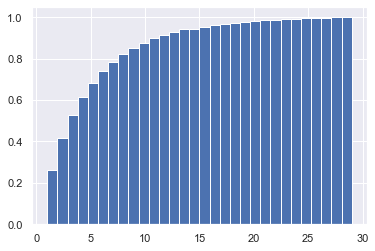

In [17]:
player_battles = arena_members.groupby('account_db_id')['account_db_id'].count()

battles_critical = np.percentile(player_battles, 65)
print(f'Critical battles number = {battles_critical}')

plt.hist(player_battles[player_battles < 30], bins=30, density=True, cumulative=True)
plt.show()

In [18]:
N = len(arena_members)

print('[FILTERING BY CRITICAL BATTLES NUMBER...]', end='   ')
arena_members = arena_members[arena_members.groupby('account_db_id')['account_db_id'].transform('count') > battles_critical]
print(f'[FILTERED: removed {N - len(arena_members)} rows.] ({100 - 100 * len(arena_members) / N} %)')

arena_members

[FILTERING BY CRITICAL BATTLES NUMBER...]   [FILTERED: removed 724425 rows.] (30.349641443342932 %)


,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_winner
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,16533,0,0,0,1,9,2,3075,6.316667,True
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,4468,0,0,0,1,9,2,2607,6.316667,True
7,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,101557,1310,0,1343,1,9,2,2401,5.616667,True
8,2018-09-16,7N1T221ccNyadyccT,202,cac4a2121,2,0,0,0,529,379,...,25209,0,0,0,1,9,2,1659,6.316667,True
12,2018-09-16,7N1T221ccNyadyccT,202,caa4TTcdc,1,0,0,0,2593,259,...,6195,0,0,0,1,9,2,81,4.316667,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386925,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,13135,0,0,0,1,8,1,2076,8.483333,False
2386926,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,26773,1560,0,0,1,8,1,1377,2.983333,False
2386927,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,3869,1790,0,0,1,8,1,2619,5.100000,True
2386928,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,58261,390,0,0,1,8,1,1011,5.566667,False


In [19]:
players_for_train = arena_members[arena_members.groupby('account_db_id')['account_db_id'].transform('count') >= 10]
players_for_train = players_for_train.groupby('account_db_id').agg({'original_xp' : 'mean',
                                                                    'remained_hp' : 'mean',
                                                                    'kills_made' : 'mean',
                                                                    'total_damage_dealt' : 'mean',
                                                                    'damaged' : 'mean',
                                                                    'pierced' : 'mean',
                                                                    'original_credits' : 'mean',
                                                                    'hits' : 'mean',
                                                                    'life_time_min' : 'mean',
                                                                    'damage_assisted_track' : 'mean',
                                                                    'spotted' : 'mean',
                                                                    'pierced_received' : 'mean',
                                                                    'is_winner' : lambda g: sum(g) / len(g)})

features = ['mean_original_xp', 'mean_remained_hp', 'mean_kills_made', 'mean_total_damage_dealt',
                            'mean_damaged', 'mean_pierced', 'mean_original_credits', 'mean_hits',
                            'mean_life_time_min', 'mean_damage_assisted_track', 'mean_spotted', 'mean_pierced_received']
target = ['player_winrate']
players_for_train.columns = features + target

players_for_train

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate
account_db_id,,,,,,,,,,,,,
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000
c21117c21,1003.500000,125.500000,0.900000,1171.400000,1.600000,2.000000,20049.000000,3.100000,4.856667,18.100000,0.400000,3.900000,0.400000
c21117yd2,1258.700000,242.200000,0.500000,1830.800000,3.500000,5.000000,29542.100000,8.000000,4.896667,215.400000,0.900000,4.200000,0.500000
c2111Ncyd,1456.937500,174.229167,1.062500,2285.625000,3.937500,6.645833,70518.937500,9.583333,4.234722,112.916667,1.583333,3.645833,0.583333
c2111TTa7,267.923077,166.769231,0.307692,469.692308,1.461538,1.923077,7834.153846,4.153846,5.701282,0.000000,0.307692,2.615385,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyydN4N,717.600000,25.600000,0.400000,792.800000,2.100000,2.200000,19133.900000,4.000000,4.303333,82.000000,0.300000,4.300000,0.400000
cyyyydyNa,1348.230769,61.615385,0.461538,958.923077,1.692308,2.076923,39881.307692,2.846154,2.833333,57.307692,2.076923,4.000000,0.461538
cyyyyy2y2,1387.592593,197.111111,0.703704,1642.666667,2.444444,3.296296,48332.925926,4.555556,4.640741,212.407407,1.222222,3.444444,0.629630


In [21]:
players_feature_scaler, players_winrate_scaler = StandardScaler(), StandardScaler()

Xn = players_feature_scaler.fit_transform(players_for_train[features])
Yn = players_winrate_scaler.fit_transform(players_for_train[target])

pcaWinrate = PCA(n_components=0.95)
pcaWinrate_components = pcaWinrate.fit_transform(Xn)

numWinrateComponents = pcaWinrate_components.shape[1]

model = GradientBoostingRegressor(n_estimators=300, max_depth=8)
model.fit(Xn, Yn.reshape(len(Yn),))

preds = model.predict(Xn)
mean_squared_error(Yn, preds)

0.36484396351706105

In [22]:
players_data = arena_members.groupby('account_db_id').agg({'original_xp' : 'mean',
                                                           'remained_hp' : 'mean',
                                                           'kills_made' : 'mean',
                                                           'total_damage_dealt' : 'mean',
                                                           'damaged' : 'mean',
                                                           'pierced' : 'mean',
                                                           'original_credits' : 'mean',
                                                           'hits' : 'mean',
                                                           'life_time_min' : 'mean',
                                                           'damage_assisted_track' : 'mean',
                                                           'spotted' : 'mean',
                                                           'pierced_received' : 'mean',
                                                           'is_winner' : lambda g: sum(g) / len(g)})
players_data.columns = features + target

players_data

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate
account_db_id,,,,,,,,,,,,,
c21112TT1,965.000000,69.000000,0.571429,1753.285714,2.142857,5.000000,23514.000000,5.857143,3.759524,231.857143,1.428571,5.000000,0.571429
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000
c21114TaT,784.111111,149.777778,1.333333,2595.000000,5.222222,6.111111,29309.888889,9.444444,5.453704,55.444444,1.222222,4.111111,0.555556
c211172d7,595.142857,256.285714,0.857143,1366.142857,2.714286,4.142857,27680.428571,5.000000,3.876190,35.000000,1.428571,4.142857,0.285714
c211177a2,1251.000000,522.833333,1.166667,1982.500000,3.500000,3.666667,18619.000000,5.833333,4.986111,539.666667,0.333333,3.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyy2ac,1098.375000,212.375000,0.375000,1556.125000,3.125000,3.375000,41397.625000,5.125000,4.679167,0.000000,0.250000,3.500000,0.500000
cyyyyy2y2,1387.592593,197.111111,0.703704,1642.666667,2.444444,3.296296,48332.925926,4.555556,4.640741,212.407407,1.222222,3.444444,0.629630
cyyyyy2yd,1025.090909,222.545455,0.545455,2218.272727,2.818182,3.000000,31261.636364,3.909091,4.245455,72.909091,1.000000,3.181818,0.545455


In [23]:
players_features_normed = players_feature_scaler.transform(players_data[features])
winrateComponents = pcaWinrate.transform(players_features_normed)[:, numWinrateComponents - 1]

players_winrate_normed = model.predict(players_features_normed)
players_data['player_winrate_ML'] = players_winrate_scaler.inverse_transform(players_winrate_normed)

players_data['player_winrate_ML'][players_data['player_winrate_ML'] < 0] = 0
players_data['player_winrate_ML'][players_data['player_winrate_ML'] > 1] = 1

players_data

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate,player_winrate_ML
account_db_id,,,,,,,,,,,,,,
c21112TT1,965.000000,69.000000,0.571429,1753.285714,2.142857,5.000000,23514.000000,5.857143,3.759524,231.857143,1.428571,5.000000,0.571429,0.513296
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000,0.522096
c21114TaT,784.111111,149.777778,1.333333,2595.000000,5.222222,6.111111,29309.888889,9.444444,5.453704,55.444444,1.222222,4.111111,0.555556,0.454719
c211172d7,595.142857,256.285714,0.857143,1366.142857,2.714286,4.142857,27680.428571,5.000000,3.876190,35.000000,1.428571,4.142857,0.285714,0.455307
c211177a2,1251.000000,522.833333,1.166667,1982.500000,3.500000,3.666667,18619.000000,5.833333,4.986111,539.666667,0.333333,3.333333,0.500000,0.650314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyy2ac,1098.375000,212.375000,0.375000,1556.125000,3.125000,3.375000,41397.625000,5.125000,4.679167,0.000000,0.250000,3.500000,0.500000,0.474884
cyyyyy2y2,1387.592593,197.111111,0.703704,1642.666667,2.444444,3.296296,48332.925926,4.555556,4.640741,212.407407,1.222222,3.444444,0.629630,0.568518
cyyyyy2yd,1025.090909,222.545455,0.545455,2218.272727,2.818182,3.000000,31261.636364,3.909091,4.245455,72.909091,1.000000,3.181818,0.545455,0.537232


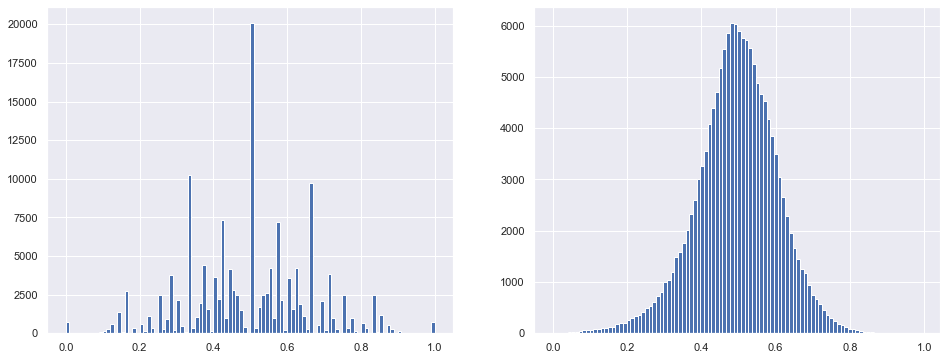

0.4947491959747243

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(players_data['player_winrate'], bins=100)
axes[1].hist(players_data['player_winrate_ML'], bins=100)
plt.show()

players_data['player_winrate_ML'].mean()

In [25]:
arena_members = arena_members.merge(players_data[['player_winrate_ML']], how='left', on='account_db_id')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_winner,player_winrate_ML
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,0,0,0,1,9,2,3075,6.316667,True,0.588878
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,0,0,0,1,9,2,2607,6.316667,True,0.488365
2,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,1310,0,1343,1,9,2,2401,5.616667,True,0.432511
3,2018-09-16,7N1T221ccNyadyccT,202,cac4a2121,2,0,0,0,529,379,...,0,0,0,1,9,2,1659,6.316667,True,0.580664
4,2018-09-16,7N1T221ccNyadyccT,202,caa4TTcdc,1,0,0,0,2593,259,...,0,0,0,1,9,2,81,4.316667,False,0.517746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662501,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,0,0,0,1,8,1,2076,8.483333,False,0.393219
1662502,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,1560,0,0,1,8,1,1377,2.983333,False,0.405415
1662503,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1790,0,0,1,8,1,2619,5.100000,True,0.617668
1662504,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,390,0,0,1,8,1,1011,5.566667,False,0.616335


Critical battles number = 103


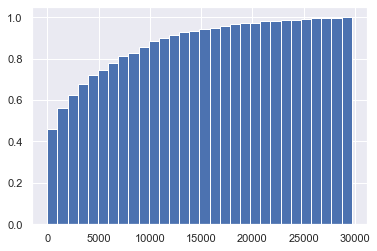

In [26]:
tank_battles = arena_members.groupby('vehicle_type_cd')['vehicle_type_cd'].count()

battles_critical = int(np.percentile(tank_battles, 15))
print(f'Critical battles number = {battles_critical}')

plt.hist(tank_battles[tank_battles < 35000], bins=30, density=True, cumulative=True)
plt.show()

In [27]:
N0 = len(arena_members)

masks = [
    (f'cleaning by tank battles: vehicle_type_cd.grouped.count >= {battles_critical}', \
    arena_members.groupby('vehicle_type_cd')['vehicle_type_cd'].transform('count') > battles_critical),
    
    ('cleaning by afk: mileage_meter == 0 & damage_dealt == 0', \
    (arena_members['mileage_meter'] != 0) | (arena_members['damage_dealt'] != 0))
]

for mask in masks:
    N = len(arena_members)
    
    arena_members = arena_members.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N)} %)')
    
arena_members.index = np.arange(len(arena_members))

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

[CLEANING BY TANK BATTLES: VEHICLE_TYPE_CD.GROUPED.COUNT >= 103]: removed 2807 rows. (0.16884149591038788 %)
[CLEANING BY AFK: MILEAGE_METER == 0 & DAMAGE_DEALT == 0]: removed 2543 rows. (0.15322055384741073 %)

Totally removed 5350 rows. (0.32180334988264336 %)


In [28]:
tanks_data = arena_members.groupby('vehicle_type_cd').agg({'is_winner' : lambda g: sum(g) / len(g)})
tanks_data.columns = ['tank_winrate']

tanks_data

,tank_winrate
vehicle_type_cd,
49,0.506267
145,0.463636
273,0.464602
305,0.519171
513,0.511283
...,...
64065,0.500746
64273,0.471309
64561,0.505991


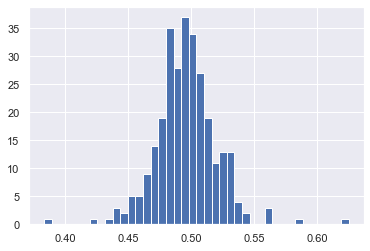

0.4960140233751385

In [29]:
plt.hist(tanks_data['tank_winrate'], bins=40)
plt.show()

tanks_data['tank_winrate'].mean()

In [30]:
arena_members = arena_members.merge(tanks_data[['tank_winrate']], how='left', on='vehicle_type_cd')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_winner,player_winrate_ML,tank_winrate
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,0,0,1,9,2,3075,6.316667,True,0.588878,0.506973
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,0,0,1,9,2,2607,6.316667,True,0.488365,0.493767
2,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,0,1343,1,9,2,2401,5.616667,True,0.432511,0.505860
3,2018-09-16,7N1T221ccNyadyccT,202,cac4a2121,2,0,0,0,529,379,...,0,0,1,9,2,1659,6.316667,True,0.580664,0.483986
4,2018-09-16,7N1T221ccNyadyccT,202,caa4TTcdc,1,0,0,0,2593,259,...,0,0,1,9,2,81,4.316667,False,0.517746,0.485520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,0,0,1,8,1,2076,8.483333,False,0.393219,0.488701
1657152,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,0,0,1,8,1,1377,2.983333,False,0.405415,0.497093
1657153,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,0,0,1,8,1,2619,5.100000,True,0.617668,0.495933
1657154,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,0,0,1,8,1,1011,5.566667,False,0.616335,0.515528


In [31]:
arena_members.drop(columns=['dt', 'periphery_id', 'team_id', 'clan_db_id', 'prebattle_id', 'is_prebattle_creator',
                            'life_time_sec', 'shots', 'hits', 'he_hits', 'pierced', 'mileage_meter', 'premium_xp_factor',
                            'daily_xp_factor', 'battle_num', 'remained_hp', 'is_alive', 'winner_team_id',
                            'winner_team_id_my', 'is_winner', 'is_winner_my'], inplace=True, axis=1)
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_winner,player_winrate_ML,tank_winrate
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,0,0,1,9,2,3075,6.316667,True,0.588878,0.506973
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,0,0,1,9,2,2607,6.316667,True,0.488365,0.493767
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,0,1343,1,9,2,2401,5.616667,True,0.432511,0.505860
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,0,0,1,9,2,1659,6.316667,True,0.580664,0.483986
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,0,0,1,9,2,81,4.316667,False,0.517746,0.485520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,0,0,1,8,1,2076,8.483333,False,0.393219,0.488701
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,0,0,1,8,1,1377,2.983333,False,0.405415,0.497093
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,0,0,1,8,1,2619,5.100000,True,0.617668,0.495933
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,0,0,1,8,1,1011,5.566667,False,0.616335,0.515528


# Creating new features

In [33]:
arena_members = arena_members.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
arena_members.drop(['item_cd'], axis=1, inplace=True)
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,total_damage_dealt,life_time_min,is_winner,player_winrate_ML,tank_winrate,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,3075,6.316667,True,0.588878,0.506973,1,2700000,0,8,6
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,2607,6.316667,True,0.488365,0.493767,2,2568500,0,8,4
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,2401,5.616667,True,0.432511,0.505860,2,2600000,0,8,4
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,1659,6.316667,True,0.580664,0.483986,2,1390000,0,7,5
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,81,4.316667,False,0.517746,0.485520,0,3550000,0,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,2076,8.483333,False,0.393219,0.488701,0,0,5950,7,4
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,1377,2.983333,False,0.405415,0.497093,2,0,11800,8,4
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,2619,5.100000,True,0.617668,0.495933,2,0,12250,8,4
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,1011,5.566667,False,0.616335,0.515528,2,0,5250,7,4


In [46]:
arena_members['battle_lvl_weight'] = (arena_members['battle_level_id'] - arena_members['item_level']) / 2 + 1
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,life_time_min,is_winner,player_winrate_ML,tank_winrate,item_class,item_price_credit,item_price_gold,item_level,crew_size,battle_lvl_weight
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,6.316667,True,0.588878,0.506973,1,2700000,0,8,6,1.5
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,6.316667,True,0.488365,0.493767,2,2568500,0,8,4,1.5
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,5.616667,True,0.432511,0.505860,2,2600000,0,8,4,1.5
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,6.316667,True,0.580664,0.483986,2,1390000,0,7,5,2.0
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,4.316667,False,0.517746,0.485520,0,3550000,0,9,6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,8.483333,False,0.393219,0.488701,0,0,5950,7,4,1.5
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,2.983333,False,0.405415,0.497093,2,0,11800,8,4,1.0
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,5.100000,True,0.617668,0.495933,2,0,12250,8,4,1.0
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,5.566667,False,0.616335,0.515528,2,0,5250,7,4,1.5


In [47]:
for f in ['kills_made', 'damage_dealt', 'damage_assisted_radio', 'damage_assisted_track', 'damage_blocked_by_armor']:
    arena_members[f + '_normed_by_lvl'] = arena_members[f] * arena_members['battle_lvl_weight']
    
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,item_price_credit,item_price_gold,item_level,crew_size,battle_lvl_weight,kills_made_normed_by_lvl,damage_dealt_normed_by_lvl,damage_assisted_radio_normed_by_lvl,damage_assisted_track_normed_by_lvl,damage_blocked_by_armor_normed_by_lvl
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,2700000,0,8,6,1.5,3.0,2818.5,0.0,0.0,0.0
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,2568500,0,8,4,1.5,1.5,3345.0,565.5,0.0,0.0
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,2600000,0,8,4,1.5,3.0,2679.0,922.5,0.0,1965.0
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,1390000,0,7,5,2.0,4.0,3318.0,0.0,0.0,0.0
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,3550000,0,9,6,1.0,0.0,0.0,81.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,0,5950,7,4,1.5,1.5,3090.0,24.0,0.0,0.0
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,0,11800,8,4,1.0,0.0,1377.0,0.0,0.0,1560.0
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,0,12250,8,4,1.0,1.0,1479.0,1140.0,0.0,1790.0
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,0,5250,7,4,1.5,0.0,160.5,630.0,726.0,585.0


In [48]:
f = arena_members.groupby(['vehicle_type_cd', 'account_db_id'])[['original_credits',
                                                                 'booster_bonus_credits',
                                                                 'booster_bonus_xp',
                                                                 'kills_made_normed_by_lvl',
                                                                 'damage_dealt_normed_by_lvl',
                                                                 'damage_assisted_radio_normed_by_lvl',
                                                                 'damage_assisted_track_normed_by_lvl',
                                                                 'damage_blocked_by_armor_normed_by_lvl',
                                                                 'player_winrate_ML']].mean()

f['normed_kills_made'] = (1 - f['player_winrate_ML']) * f['kills_made_normed_by_lvl']
f['normed_damage_dealt'] = (1 - f['player_winrate_ML']) * f['damage_dealt_normed_by_lvl']
f['normed_damage_assisted_radio'] = (1 - f['player_winrate_ML']) * f['damage_assisted_radio_normed_by_lvl']
f['normed_damage_assisted_track'] = (1 - f['player_winrate_ML']) * f['damage_assisted_track_normed_by_lvl']
f['normed_damage_blocked_by_armor'] = (1 - f['player_winrate_ML']) * f['damage_blocked_by_armor_normed_by_lvl']

f = f.groupby(level=0)[['original_credits', 'booster_bonus_credits', 'booster_bonus_xp', 'normed_kills_made',
                        'normed_damage_dealt', 'normed_damage_assisted_radio', 'normed_damage_assisted_track',
                        'normed_damage_blocked_by_armor']].mean()
f = f.rename(columns={'original_credits': 'mean_original_credits',
                      'booster_bonus_credits': 'mean_booster_bonus_credits',
                      'booster_bonus_xp': 'mean_booster_bonus_xp'})
f

,mean_original_credits,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
vehicle_type_cd,,,,,,,,
49,52744.904169,5914.493574,112.688497,0.410861,651.463510,299.665659,56.668577,305.879589
145,22217.781818,605.836364,124.827273,0.421145,458.575776,226.880604,37.479022,149.537081
273,19288.086072,389.145540,56.082160,0.665743,661.644845,13.009703,36.369050,1.092680
305,34397.767015,2640.082774,94.631406,0.449737,538.902585,586.049388,38.400082,21.860975
513,18260.754918,705.533026,143.282279,0.438018,650.555958,221.552493,50.687683,266.171070
...,...,...,...,...,...,...,...,...
64065,46625.755665,5559.546102,94.596453,0.413952,651.471982,239.735515,52.243493,145.539297
64273,41422.011053,3534.833449,82.916149,0.343761,555.628229,264.103035,44.274639,87.423845
64561,47636.096574,4228.688371,98.433245,0.357014,637.154895,234.859017,46.865302,711.441493


In [49]:
arena_members = arena_members.merge(f, how='left', on='vehicle_type_cd')
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,damage_assisted_track_normed_by_lvl,damage_blocked_by_armor_normed_by_lvl,mean_original_credits,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,0.0,0.0,20414.814893,652.646466,98.266474,0.493660,844.359983,12.338198,24.418500,1.410980
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,0.0,0.0,20203.921055,625.519425,95.641616,0.400209,725.666248,204.887064,47.748966,490.027491
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,0.0,1965.0,26425.450517,1520.589973,338.595864,0.463880,802.221286,191.589469,52.323946,406.160273
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,0.0,0.0,16741.308883,509.199026,72.899851,0.433953,664.550811,247.448122,62.007117,193.315766
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,0.0,0.0,25452.981241,781.943584,101.220375,0.516188,853.790295,139.894287,32.956794,251.267981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,0.0,0.0,32573.884539,1857.629042,77.605526,0.502245,714.106555,168.111333,50.991451,1.412557
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,0.0,1560.0,43911.733073,3690.385202,86.445057,0.413825,680.640081,220.914452,55.077796,573.720612
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,0.0,1790.0,50344.435671,5533.732261,104.537622,0.382071,628.280172,225.847916,47.717205,539.813383
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,726.0,585.0,31219.834343,1701.027091,84.548292,0.479905,655.518552,228.740547,39.691387,217.115318


In [50]:
dataset = arena_members[['vehicle_type_cd', 'item_class', 'item_level', 'crew_size', 'tank_winrate',
                         'mean_original_credits', 'mean_booster_bonus_credits', 'mean_booster_bonus_xp',
                         'normed_kills_made', 'normed_damage_dealt', 'normed_damage_assisted_radio',
                         'normed_damage_assisted_track', 'normed_damage_blocked_by_armor',
                         'item_price_credit', 'item_price_gold']]
dataset

,vehicle_type_cd,item_class,item_level,crew_size,tank_winrate,mean_original_credits,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_credit,item_price_gold
0,7457,1,8,6,0.506973,20414.814893,652.646466,98.266474,0.493660,844.359983,12.338198,24.418500,1.410980,2700000,0
1,5377,2,8,4,0.493767,20203.921055,625.519425,95.641616,0.400209,725.666248,204.887064,47.748966,490.027491,2568500,0
2,2961,2,8,4,0.505860,26425.450517,1520.589973,338.595864,0.463880,802.221286,191.589469,52.323946,406.160273,2600000,0
3,529,2,7,5,0.483986,16741.308883,509.199026,72.899851,0.433953,664.550811,247.448122,62.007117,193.315766,1390000,0
4,2593,0,9,6,0.485520,25452.981241,781.943584,101.220375,0.516188,853.790295,139.894287,32.956794,251.267981,3550000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,61713,0,7,4,0.488701,32573.884539,1857.629042,77.605526,0.502245,714.106555,168.111333,50.991451,1.412557,0,5950
1657152,9217,2,8,4,0.497093,43911.733073,3690.385202,86.445057,0.413825,680.640081,220.914452,55.077796,573.720612,0,11800
1657153,65073,2,8,4,0.495933,50344.435671,5533.732261,104.537622,0.382071,628.280172,225.847916,47.717205,539.813383,0,12250
1657154,59137,2,7,4,0.515528,31219.834343,1701.027091,84.548292,0.479905,655.518552,228.740547,39.691387,217.115318,0,5250


# Correlations

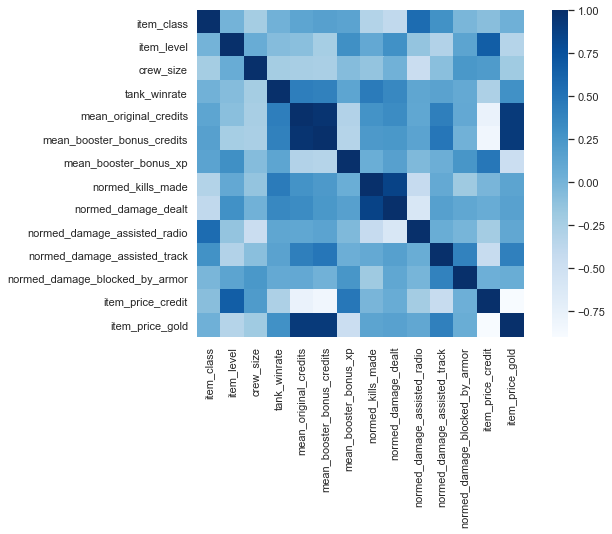

item_price_credit                -0.896133
mean_booster_bonus_xp            -0.469183
item_level                       -0.320670
crew_size                        -0.199783
item_class                        0.032083
normed_damage_blocked_by_armor    0.061129
normed_damage_assisted_radio      0.105539
normed_kills_made                 0.137963
normed_damage_dealt               0.157180
tank_winrate                      0.294401
normed_damage_assisted_track      0.421611
mean_booster_bonus_credits        0.922391
mean_original_credits             0.923494
item_price_gold                   1.000000
Name: item_price_gold, dtype: float64

In [51]:
corr = dataset.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

# Regression model

In [52]:
res_data = dataset.groupby('vehicle_type_cd').mean().reset_index()
tank_params = res_data[res_data['vehicle_type_cd'] == 9217]
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

res_data.drop(columns=['vehicle_type_cd'], inplace=True, axis=1)

features = list(res_data.columns)
features.remove('item_price_credit'); features.remove('item_price_gold')
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

credit_dataset.index = np.arange(len(credit_dataset))
gold_dataset.index = np.arange(len(gold_dataset))

gold_dataset

,item_class,item_level,crew_size,tank_winrate,mean_original_credits,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_gold
0,4,8,4,0.506267,52744.904169,5914.493574,112.688497,0.410861,651.463510,299.665659,56.668577,305.879589,7500
1,4,6,5,0.463636,22217.781818,605.836364,124.827273,0.421145,458.575776,226.880604,37.479022,149.537081,3650
2,3,7,4,0.519171,34397.767015,2640.082774,94.631406,0.449737,538.902585,586.049388,38.400082,21.860975,4800
3,2,8,4,0.507127,47316.228314,4826.550578,86.013164,0.382484,674.273887,257.881839,53.017145,551.503662,12250
4,2,8,4,0.520461,53420.673371,5215.581389,139.423831,0.479357,827.179385,223.021186,47.004791,536.609320,10700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2,8,5,0.500746,46625.755665,5559.546102,94.596453,0.413952,651.471982,239.735515,52.243493,145.539297,11900
74,4,8,4,0.471309,41422.011053,3534.833449,82.916149,0.343761,555.628229,264.103035,44.274639,87.423845,8700
75,2,8,4,0.505991,47636.096574,4228.688371,98.433245,0.357014,637.154895,234.859017,46.865302,711.441493,10500
76,3,6,5,0.527875,25841.512456,1227.861210,67.414591,0.488858,473.897083,430.036338,21.240354,1.101403,3500


In [53]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

,item_class,item_level,crew_size,tank_winrate,mean_original_credits,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_price_gold
0,1.100149,0.563093,-0.505361,0.086615,0.989377,1.187345,0.992004,-0.405210,-0.231388,0.353144,0.764002,0.078213,-0.379081
1,1.100149,-2.815463,0.853887,-1.999644,-2.118606,-2.029168,1.620069,-0.292982,-1.871933,-0.382646,-0.729393,-0.540155,-1.857688
2,0.408120,-1.126185,-0.505361,0.718087,-0.878555,-0.796619,0.057724,0.019057,-1.188739,3.248222,-0.657713,-1.045141,-1.416026
3,-0.283909,0.563093,-0.505361,0.128704,0.436680,0.528161,-0.388187,-0.714903,-0.037381,-0.069252,0.479835,1.049708,1.445175
4,-0.283909,0.563093,-0.505361,0.781236,1.058177,0.763875,2.375300,0.342306,1.263108,-0.421661,0.011934,0.990797,0.849891
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,-0.283909,0.563093,0.853887,-0.183598,0.366383,0.972283,0.055916,-0.371477,-0.231315,-0.252695,0.419627,-0.555967,1.310756
74,1.100149,0.563093,-0.505361,-1.624141,-0.163413,-0.254490,-0.548427,-1.137497,-1.046484,-0.006361,-0.200536,-0.785826,0.081784
75,-0.283909,0.563093,-0.505361,0.073079,0.469246,0.165917,0.254433,-0.992860,-0.353085,-0.301992,0.001078,1.682296,0.773081
76,0.408120,-2.815463,0.853887,1.144019,-1.749672,-1.652283,-1.350484,0.445996,-1.741623,1.671073,-1.993141,-1.127249,-1.915296


In [54]:
train_data = np.array(normed_gold_dataset.drop(columns=['item_price_gold']))
train_labels = np.array(normed_gold_dataset[['item_price_gold']])

Train on 62 samples, validate on 16 samples
Epoch 1/120
62/62 [==============================] - 1s 10ms/sample - loss: 0.7977 - val_loss: 0.5681
Epoch 2/120
62/62 [==============================] - 0s 265us/sample - loss: 0.5935 - val_loss: 0.4440
Epoch 3/120
62/62 [==============================] - 0s 290us/sample - loss: 0.4648 - val_loss: 0.3894
Epoch 4/120
62/62 [==============================] - 0s 290us/sample - loss: 0.4126 - val_loss: 0.3521
Epoch 5/120
62/62 [==============================] - 0s 292us/sample - loss: 0.3930 - val_loss: 0.3294
Epoch 6/120
62/62 [==============================] - 0s 370us/sample - loss: 0.3048 - val_loss: 0.3072
Epoch 7/120
62/62 [==============================] - 0s 290us/sample - loss: 0.3104 - val_loss: 0.3137
Epoch 8/120
62/62 [==============================] - 0s 338us/sample - loss: 0.2524 - val_loss: 0.3032
Epoch 9/120
62/62 [==============================] - 0s 332us/sample - loss: 0.2683 - val_loss: 0.2917
Epoch 10/120
62/62 [==========

62/62 [==============================] - 0s 250us/sample - loss: 0.0319 - val_loss: 0.2384
Epoch 80/120
62/62 [==============================] - 0s 273us/sample - loss: 0.0374 - val_loss: 0.2368
Epoch 81/120
62/62 [==============================] - 0s 273us/sample - loss: 0.0514 - val_loss: 0.2537
Epoch 82/120
62/62 [==============================] - 0s 257us/sample - loss: 0.0603 - val_loss: 0.2329
Epoch 83/120
62/62 [==============================] - 0s 273us/sample - loss: 0.0473 - val_loss: 0.2404
Epoch 84/120
62/62 [==============================] - 0s 265us/sample - loss: 0.0448 - val_loss: 0.2244
Epoch 85/120
62/62 [==============================] - 0s 273us/sample - loss: 0.0372 - val_loss: 0.2366
Epoch 86/120
62/62 [==============================] - 0s 257us/sample - loss: 0.0388 - val_loss: 0.2344
Epoch 87/120
62/62 [==============================] - 0s 290us/sample - loss: 0.0461 - val_loss: 0.2395
Epoch 88/120
62/62 [==============================] - 0s 338us/sample - loss:

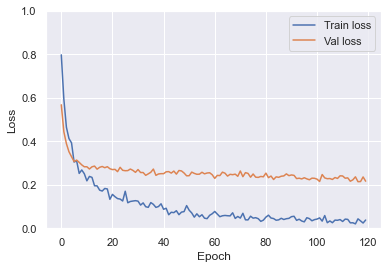

In [86]:
epochs = 120

model = build_network(train_data.shape[1])
history = model.fit(train_data, train_labels,
                    validation_split=0.2,
                    epochs=epochs, shuffle=True)

plot_network_history(history)

In [87]:
full_model = build_network(train_data.shape[1])
history = full_model.fit(train_data, train_labels,
                         epochs=epochs, shuffle=True)

Train on 78 samples
Epoch 1/120
78/78 [==============================] - 1s 7ms/sample - loss: 1.1446
Epoch 2/120
78/78 [==============================] - 0s 128us/sample - loss: 0.7174
Epoch 3/120
78/78 [==============================] - 0s 102us/sample - loss: 0.5437
Epoch 4/120
78/78 [==============================] - 0s 115us/sample - loss: 0.4822
Epoch 5/120
78/78 [==============================] - 0s 128us/sample - loss: 0.4556
Epoch 6/120
78/78 [==============================] - 0s 128us/sample - loss: 0.3172
Epoch 7/120
78/78 [==============================] - 0s 115us/sample - loss: 0.3079
Epoch 8/120
78/78 [==============================] - 0s 128us/sample - loss: 0.2417
Epoch 9/120
78/78 [==============================] - 0s 115us/sample - loss: 0.2519
Epoch 10/120
78/78 [==============================] - 0s 141us/sample - loss: 0.2609
Epoch 11/120
78/78 [==============================] - 0s 141us/sample - loss: 0.1805
Epoch 12/120
78/78 [==============================] - 0s

78/78 [==============================] - 0s 102us/sample - loss: 0.0298
Epoch 98/120
78/78 [==============================] - 0s 153us/sample - loss: 0.0281
Epoch 99/120
78/78 [==============================] - 0s 115us/sample - loss: 0.0402
Epoch 100/120
78/78 [==============================] - 0s 153us/sample - loss: 0.0385
Epoch 101/120
78/78 [==============================] - 0s 128us/sample - loss: 0.0365
Epoch 102/120
78/78 [==============================] - 0s 115us/sample - loss: 0.0321
Epoch 103/120
78/78 [==============================] - 0s 102us/sample - loss: 0.0492
Epoch 104/120
78/78 [==============================] - 0s 128us/sample - loss: 0.0378
Epoch 105/120
78/78 [==============================] - 0s 128us/sample - loss: 0.0275
Epoch 106/120
78/78 [==============================] - 0s 89us/sample - loss: 0.0307
Epoch 107/120
78/78 [==============================] - 0s 141us/sample - loss: 0.0345
Epoch 108/120
78/78 [==============================] - 0s 90us/sample -

In [56]:
tank_params.drop(columns=['vehicle_type_cd', 'item_price_credit', 'item_price_gold'], inplace=True, axis=1)
tank_params

,item_class,item_level,crew_size,tank_winrate,mean_original_credits,mean_booster_bonus_credits,mean_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
118,2,8,4,0.497093,43911.733073,3690.385202,86.445057,0.413825,680.640081,220.914452,55.077796,573.720612


In [88]:
def predict(tank_params):
    tank_params['item_price_gold'] = 0
    
    scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
    
    pred_full = full_model.predict(scaled)
    pred = model.predict(scaled)
    
    x_full = np.concatenate((scaled[0], pred_full[0]))
    x = np.concatenate((scaled[0], pred[0]))
    
    return gold_scaler.inverse_transform(x_full)[-1], gold_scaler.inverse_transform(x)[-1]

predict(tank_params)

(11520.66122000472, 10882.644477092565)

# Tests

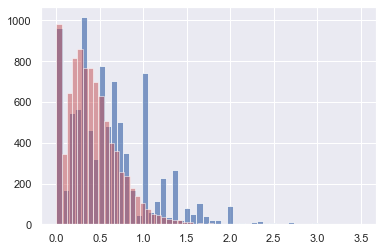

In [97]:
damage = arena_members[arena_members['vehicle_type_cd'] == 9217][['account_db_id', 'kills_made', 'kills_made_normed_by_lvl', 'player_winrate_ML']]
damage = damage[damage.groupby('account_db_id')['account_db_id'].transform('count') > 2]

pl = damage.groupby('account_db_id').agg({'kills_made' : lambda g: g.mean(),
                                          'kills_made_normed_by_lvl' : lambda g: g.mean(),
                                          'player_winrate_ML' : 'mean'})
pl['normed'] = (1 - pl['player_winrate_ML']) * pl['kills_made_normed_by_lvl']

plt.hist(pl['kills_made'], bins=50, alpha=0.7)
plt.hist(pl['normed'], bins=50, color='r', alpha=0.5)
plt.show()

In [89]:
gb = GradientBoostingRegressor(n_estimators=400, max_depth=6, min_samples_split=4)
rf = RandomForestRegressor(n_estimators=400, max_depth=10, min_samples_split=6)
svm1 = SVR(C=100, gamma=0.01, kernel='rbf')
svm2 = SVR(C=1000, gamma=0.01, coef0=1, degree=2, kernel='poly')
ab = AdaBoostRegressor(learning_rate=0.1, loss='square', n_estimators=400)
nn = KerasRegressor(build_fn=build_network, inputs=train_data.shape[1], epochs=100)
nn._estimator_type = 'regressor'

model = VotingRegressor([('gb', gb),
                         ('rf', rf),
                         ('svm1', svm1),
                         ('svm2', svm2),
                         ('ab', ab),
                         ('nn', nn)], weights=[1, 1, 1, 1, 1, 1])

res = model.fit(train_data, train_labels)

Train on 78 samples
Epoch 1/100
78/78 [==============================] - 1s 17ms/sample - loss: 1.0957
Epoch 2/100
78/78 [==============================] - 0s 141us/sample - loss: 0.7264
Epoch 3/100
78/78 [==============================] - 0s 141us/sample - loss: 0.5890
Epoch 4/100
78/78 [==============================] - 0s 141us/sample - loss: 0.4827
Epoch 5/100
78/78 [==============================] - 0s 166us/sample - loss: 0.4335
Epoch 6/100
78/78 [==============================] - 0s 153us/sample - loss: 0.3993
Epoch 7/100
78/78 [==============================] - 0s 141us/sample - loss: 0.3587
Epoch 8/100
78/78 [==============================] - 0s 153us/sample - loss: 0.3143
Epoch 9/100
78/78 [==============================] - 0s 153us/sample - loss: 0.3113
Epoch 10/100
78/78 [==============================] - 0s 141us/sample - loss: 0.2653
Epoch 11/100
78/78 [==============================] - 0s 179us/sample - loss: 0.2601
Epoch 12/100
78/78 [==============================] - 0

78/78 [==============================] - 0s 128us/sample - loss: 0.0359
Epoch 98/100
78/78 [==============================] - 0s 128us/sample - loss: 0.0386
Epoch 99/100
78/78 [==============================] - ETA: 0s - loss: 0.038 - 0s 128us/sample - loss: 0.0374
Epoch 100/100
78/78 [==============================] - 0s 141us/sample - loss: 0.0252


In [90]:
tank_params['item_price_gold'] = 0

scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
pred = model.predict(scaled)
x = np.concatenate((scaled[0], pred))

gold_scaler.inverse_transform(x)[-1]

11052.297960706821